<a href="https://colab.research.google.com/github/Serbeld/RX-COVID-19/blob/master/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lime

In [0]:
import numpy as np
import cv2
import os
from tensorflow.keras.models import load_model
from lime import lime_image
from skimage.segmentation import mark_boundaries
from google.colab.patches import cv2_imshow

from tensorflow.keras.models import load_model

In [3]:
from google.colab import drive,files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Load the best model trained
model = load_model("/content/drive/My Drive/Demo/Model")

In [0]:
def detection(link,num_c):

    cam = cv2.imread(link)
    cam = cv2.resize(cam, (512, 512), interpolation=cv2.INTER_CUBIC)
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)

    # ImagenInput
    inputoimage = cam
    x = inputoimage.reshape((-1, 512, 512, 3))
    
    predictor = model.predict(x)

    predIdxs = np.argmax(predictor, axis=1)

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(x[-1], model.predict,
                                             hide_color=0, 
                                             num_features=100
                                             ,num_samples=1000)
    

    print("Predicted:", predIdxs[-1])
    
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=True, 
                                                num_features=num_c, 
                                                hide_rest=True)
    
    mask = np.array(mark_boundaries(temp/2 +1, mask))

    kernel = np.ones((30,30),np.uint8)
    mask = cv2.dilate(mask,kernel,iterations = 2)
    mask = cv2.blur(mask,(30,30))
    mask = cv2.blur(mask,(15,15))
    mask = cv2.blur(mask,(10,10))
    mask = cv2.blur(mask,(5,5))
    mask = np.array(mask, dtype=np.uint8)
    mask = cv2.medianBlur(mask,5)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    if predIdxs[-1] == 0:
      message = 'Healthy'
      #mask = mask*0
    if predIdxs[-1] == 1:
      message = 'Pneumonia &'
      messagetwo = 'Covid-19'
    if predIdxs[-1] == 2:
      message = 'Cardiomegaly'
    if predIdxs[-1] == 3:
      message = 'Other Diseases'
    if predIdxs[-1] == 4:
      message = 'Pleural Effusion'

    mask2 = cv2.applyColorMap((mask), cv2.COLORMAP_JET) #heatmap
    mask = cv2.blur(mask,(60,60))
    mask = cv2.blur(mask,(30,30))
    mask = cv2.blur(mask,(15,15))
    mask = cv2.blur(mask,(10,10))
    mask = cv2.blur(mask,(5,5))
    mask = cv2.applyColorMap(mask, cv2.COLORMAP_HOT) #heatmap

    mask = ((mask*1.1 + mask2*0.7)/255)*(3/2)
    end = cv2.addWeighted(x[-1]/255, 0.8, mask2/255, 0.3, 0)

    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX 
  
    # org 
    org = (20, 50) 
  
    # fontScale 
    fontScale = 1.5
   
    # Blue color in BGR 
    color = (203, 194, 126) 
  
    # Line thickness of 3 px 
    thickness = 3

    # Using cv2.putText() method 
    end2 = cv2.putText((end*250),str(message), org, font,  
                   fontScale, (44,4,4), 10, cv2.LINE_AA) 
    
    # Using cv2.putText() method 
    end2 = cv2.putText((end2),str(message), org, font,  
                   fontScale, color, thickness, cv2.LINE_AA) 
    
    if message == 'Pneumonia &':
      # Using cv2.putText() method 
      end2 = cv2.putText((end2),str(messagetwo), (20,100), font,  
                   fontScale, (44,4,4), 10, cv2.LINE_AA) 
    
      # Using cv2.putText() method 
      end2 = cv2.putText((end2),str(messagetwo), (20,100), font,  
                   fontScale, color, thickness, cv2.LINE_AA) 
    
    end2 = cv2.resize(end2, (300, 300), interpolation=cv2.INTER_CUBIC)

    cv2_imshow(end2)

    print('Healthy: '+ str(int(np.round((predictor[0][0])*100)))+'%')
    print('Pneumonia & Covid-19: '+ str(int(np.round(predictor[0][1]*100)))+'%')
    print('Cardiomegaly: '+ str(int(np.round(predictor[0][2]*100)))+'%')
    print('Other Diseases: '+ str(int(np.round(predictor[0][3]*100)))+'%')
    print('Pleural Effusion: '+ str(int(np.round(predictor[0][4]*100)))+'%')

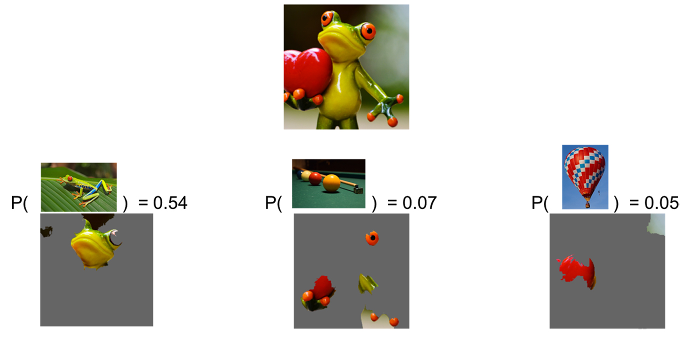

In [6]:
cam = cv2.imread("/content/drive/My Drive/Demo/Files/lime.jpg")
cam = cv2.resize(cam,None,fx=0.5,fy=0.5, interpolation=cv2.INTER_CUBIC)
cv2_imshow(cam)


Predicted: 2


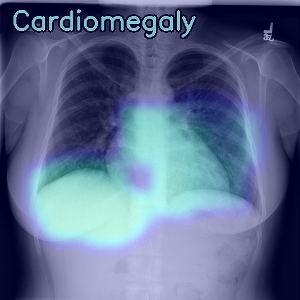

Healthy: 0%
Pneumonia & Covid-19: 0%
Cardiomegaly: 100%
Other Diseases: 0%
Pleural Effusion: 0%


In [9]:
ruta = '/content/drive/My Drive/Demo/Test/Cardiomegaly/Cardiomegaly_762.png'
#ruta = "/content/drive/My Drive/Demo/Test/PneumoCov/PneumoCov_988.png"
#ruta = "/content/drive/My Drive/Demo/Test/Others/Others_277.png"
#ruta = "/content/drive/My Drive/Demo/Test/Efussion/Efussion_122.png"
#ruta = "/content/drive/My Drive/Demo/Test/Normal/Normal_158.png"
num_charact = 8

detection(ruta,num_charact)